In [ ]:
# Standard libraries
import sys  # System-specific parameters and functions
import os   # Miscellaneous operating system interfaces
import warnings  # Warning control
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np

# LOADING THE DATASET
import gdown

# Google Sheets URL (Updated)
google_sheets_url = "https://docs.google.com/spreadsheets/d/1-W2T0UeZuK7Wk1_3tlV14iFMlIAadczV/export?format=xlsx"

# Download file
output_file = 'Residuals_SVR_Predictions_SARIMA.xlsx'
gdown.download(google_sheets_url, output=output_file, quiet=False)

# Load data
data = pd.read_excel(output_file)

# Initial display
print(data.head())

# Copy and explore
df = data.copy()
print(df.columns)

# Display column names
df.columns


In [ ]:



# Set 'Date' as the index
df.set_index('Date', inplace=True)
df


In [ ]:
df_backup=df.copy()
df_backup

In [ ]:
df=df[["Residuals_SVR"]]
df

In [ ]:
data=df.copy()
data

# ALL

## 1

In [ ]:
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

df=data.copy()
df = df.astype(float)

# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


# Number of lags to create
lags = 1
lagged_features = create_lagged_features(df, lags)

print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]
train_data
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])
train_data
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-06-02 10:24:56,687] A new study created in memory with name: no-name-e76f6c8b-a838-4d95-b05b-87a75e8358f3
[I 2025-06-02 10:25:46,089] Trial 0 finished with value: 0.009484096895903349 and parameters: {'input_units': 112, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.4483700869518506, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 90}. Best is trial 0 with value: 0.009484096895903349.
[I 2025-06-02 10:25:52,103] Trial 1 finished with value: 0.011899068020284176 and parameters: {'input_units': 96, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.21056852131976472, 'n_units_1': 64, 'dropout_rate_1': 0.03559646438439784, 'optimizer': 'RMSprop', 'batch_size': 48, 'epochs': 10}. Best is trial 0 with value: 0.009484096895903349.
[I 2025-06-02 10:26:25,418] Trial 2 finished with value: 0.009237009566277266 and parameters: {'input_units': 16, 'activation': 'sigmoid', 'num_layers': 3, 'n_units_0': 48, 'dropout_rate_0': 0.19047

Best hyperparameters:  {'input_units': 64, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 32, 'dropout_rate_0': 0.3589515684644149, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}


Best hyperparameters:  {'input_units': 112, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 96, 'dropout_rate_0': 0.4911298147309582, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 90}

Best hyperparameters:  {'input_units': 64, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 32, 'dropout_rate_0': 0.3589515684644149, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 40}
Epoch 1/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.2333 - mae: 0.3829 - val_loss: 0.0454 - val_mae: 0.1139
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2448 - mae: 0.3973 - val_loss: 0.0505 - val_mae: 0.1318
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2225 - mae: 0.3782 - val_loss: 0.0408 - val_mae: 0.1065
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.2119 - mae: 0.3804 - val_loss: 0.0392 - val_mae: 0.1053
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.2064 - mae: 0.3657 - val_loss: 0.0426 - val_mae: 0.1081
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1627 - mae: 0.3142 - val_loss: 0.0451 - val_mae: 0.1130
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1605 - mae: 0.3229 - val_loss: 0.0465 - val_mae: 0.117

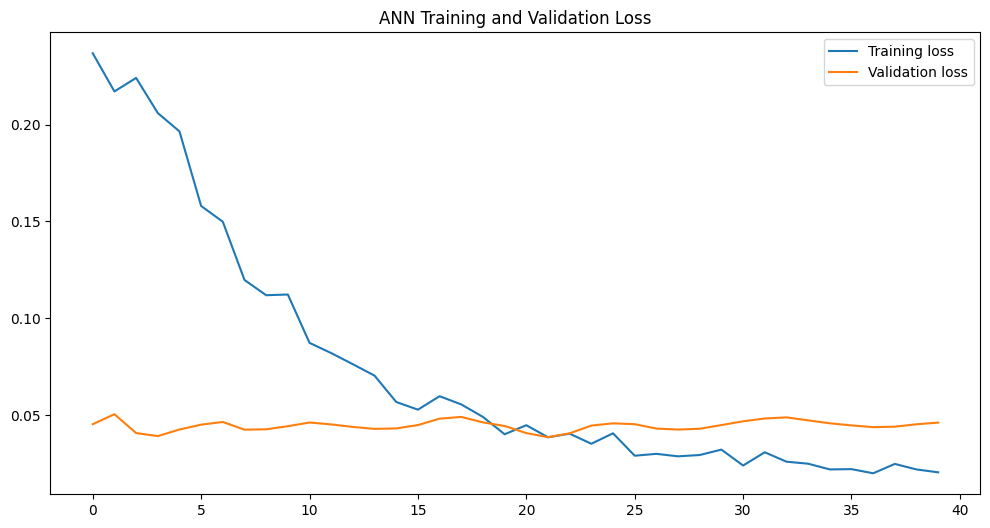

In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [9]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [10]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 9.9701
RMSE: 3.1575
MAE: 1.8757
MAPE: 189.96%
R²: -0.0494


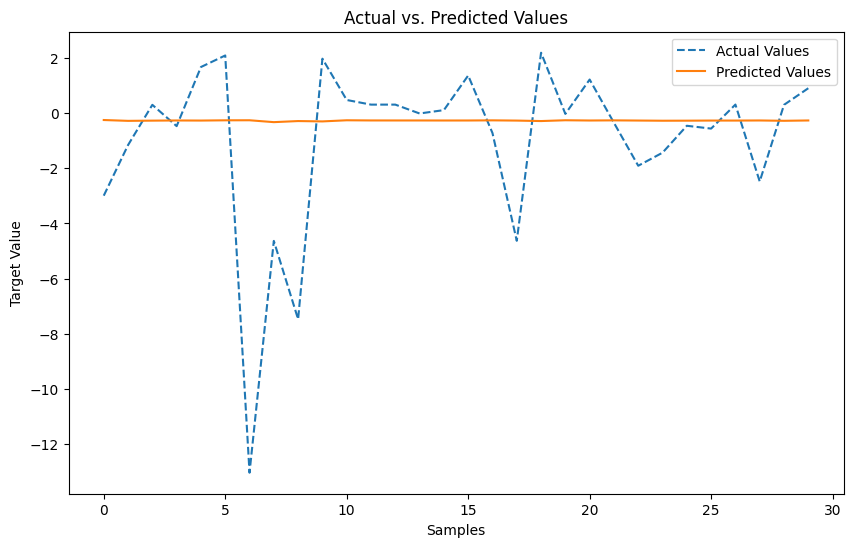

In [11]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 2

In [12]:
data

,Residuals_SVR
Date,
2000-10-31,0.008275
2000-11-30,-0.305147
2000-12-31,3.588124
2001-01-31,4.862272
2001-02-28,-1.912424
...,...
2024-11-30,-0.563288
2024-12-31,0.307545
2025-01-31,-2.480250


In [13]:
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

df=data.copy()
df = df.astype(float)


In [14]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [15]:
# Number of lags to create
lags = 2
lagged_features = create_lagged_features(df, lags)


In [16]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Residuals_SVR
Date                     
2000-10-31       0.008275
2000-11-30      -0.305147
2000-12-31       3.588124
2001-01-31       4.862272
2001-02-28      -1.912424
...                   ...
2024-11-30      -0.563288
2024-12-31       0.307545
2025-01-31      -2.480250
2025-02-28       0.297586
2025-03-31       0.899539

[294 rows x 1 columns]


In [17]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Residuals_SVR  Residuals_SVR_lag_1  Residuals_SVR_lag_2
Date                                                               
2000-10-31       0.008275                  NaN                  NaN
2000-11-30      -0.305147             0.008275                  NaN
2000-12-31       3.588124            -0.305147             0.008275
2001-01-31       4.862272             3.588124            -0.305147
2001-02-28      -1.912424             4.862272             3.588124
...                   ...                  ...                  ...
2024-11-30      -0.563288            -0.461114            -1.436900
2024-12-31       0.307545            -0.563288            -0.461114
2025-01-31      -2.480250             0.307545            -0.563288
2025-02-28       0.297586            -2.480250             0.307545
2025-03-31       0.899539             0.297586            -2.480250

[294 rows x 3 columns]


In [18]:
print(lagged_features.columns)

Index(['Residuals_SVR', 'Residuals_SVR_lag_1', 'Residuals_SVR_lag_2'], dtype='object')


In [19]:
df2=lagged_features.dropna()

In [20]:
print(df2)
len(df2)

            Residuals_SVR  Residuals_SVR_lag_1  Residuals_SVR_lag_2
Date                                                               
2000-12-31       3.588124            -0.305147             0.008275
2001-01-31       4.862272             3.588124            -0.305147
2001-02-28      -1.912424             4.862272             3.588124
2001-03-31      -4.553144            -1.912424             4.862272
2001-04-30       1.766259            -4.553144            -1.912424
...                   ...                  ...                  ...
2024-11-30      -0.563288            -0.461114            -1.436900
2024-12-31       0.307545            -0.563288            -0.461114
2025-01-31      -2.480250             0.307545            -0.563288
2025-02-28       0.297586            -2.480250             0.307545
2025-03-31       0.899539             0.297586            -2.480250

[292 rows x 3 columns]


292

In [21]:
df2.isnull().sum()

,0
Residuals_SVR,0
Residuals_SVR_lag_1,0
Residuals_SVR_lag_2,0


In [22]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [23]:
df2

,Residuals_SVR,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,,
2000-12-31,3.588124,-0.305147,0.008275
2001-01-31,4.862272,3.588124,-0.305147
2001-02-28,-1.912424,4.862272,3.588124
2001-03-31,-4.553144,-1.912424,4.862272
2001-04-30,1.766259,-4.553144,-1.912424
...,...,...,...
2024-11-30,-0.563288,-0.461114,-1.436900
2024-12-31,0.307545,-0.563288,-0.461114
2025-01-31,-2.480250,0.307545,-0.563288


In [24]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [25]:
train_data

,Residuals_SVR,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,,
2000-12-31,3.588124,-0.305147,0.008275
2001-01-31,4.862272,3.588124,-0.305147
2001-02-28,-1.912424,4.862272,3.588124
2001-03-31,-4.553144,-1.912424,4.862272
2001-04-30,1.766259,-4.553144,-1.912424
...,...,...,...
2022-05-31,5.615758,9.835432,3.163297
2022-06-30,11.736290,5.615758,9.835432
2022-07-31,0.011420,11.736290,5.615758


In [26]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [27]:
train_data

,Residuals_SVR,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,,
2000-12-31,3.588124,-0.305147,0.008275
2001-01-31,4.862272,3.588124,-0.305147
2001-02-28,-1.912424,4.862272,3.588124
2001-03-31,-4.553144,-1.912424,4.862272
2001-04-30,1.766259,-4.553144,-1.912424
...,...,...,...
2022-05-31,5.615758,9.835432,3.163297
2022-06-30,11.736290,5.615758,9.835432
2022-07-31,0.011420,11.736290,5.615758


In [28]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

,Residuals_SVR
Date,
2022-10-31,-2.994717
2022-11-30,-1.160529
2022-12-31,0.298351
2023-01-31,-0.474069
2023-02-28,1.667860
2023-03-31,2.086411
2023-04-30,-13.035113
2023-05-31,-4.632998
2023-06-30,-7.471687


In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
xtrain.columns

Index(['Residuals_SVR_lag_1', 'Residuals_SVR_lag_2'], dtype='object')

In [31]:
ytrain

,Residuals_SVR
Date,
2000-12-31,3.588124
2001-01-31,4.862272
2001-02-28,-1.912424
2001-03-31,-4.553144
2001-04-30,1.766259
...,...
2022-05-31,5.615758
2022-06-30,11.736290
2022-07-31,0.011420


In [32]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [33]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [34]:
xtrain

,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,
2000-12-31,-0.305147,0.008275
2001-01-31,3.588124,-0.305147
2001-02-28,4.862272,3.588124
2001-03-31,-1.912424,4.862272
2001-04-30,-4.553144,-1.912424
...,...,...
2022-05-31,9.835432,3.163297
2022-06-30,5.615758,9.835432
2022-07-31,11.736290,5.615758


In [35]:
df1=pd.DataFrame(ytrain)

In [36]:
X_train_scaled

array([[0.26078235, 0.28002317],
       [0.49978827, 0.26078235],
       [0.57800757, 0.49978827],
       [0.16211246, 0.57800757],
       [0.        , 0.16211246],
       [0.38794492, 0.        ],
       [0.45578505, 0.38794492],
       [0.15981909, 0.45578505],
       [0.26106888, 0.15981909],
       [0.21637214, 0.26106888],
       [0.52287011, 0.21637214],
       [0.13383955, 0.52287011],
       [0.3911197 , 0.13383955],
       [0.00504757, 0.3911197 ],
       [0.25923566, 0.00504757],
       [0.29854922, 0.25923566],
       [0.51887598, 0.29854922],
       [0.04199675, 0.51887598],
       [0.42603605, 0.04199675],
       [0.27704006, 0.42603605],
       [0.26158229, 0.27704006],
       [0.21708934, 0.26158229],
       [0.1726411 , 0.21708934],
       [0.39920846, 0.1726411 ],
       [0.29331057, 0.39920846],
       [0.44224208, 0.29331057],
       [0.34302778, 0.44224208],
       [0.05714548, 0.34302778],
       [0.12593844, 0.05714548],
       [0.37578395, 0.12593844],
       [0.

In [37]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [38]:
X_train_scaled_df

,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,
2000-12-31,0.260782,0.280023
2001-01-31,0.499788,0.260782
2001-02-28,0.578008,0.499788
2001-03-31,0.162112,0.578008
2001-04-30,0.000000,0.162112
...,...,...
2022-05-31,0.883307,0.473708
2022-06-30,0.624264,0.883307
2022-07-31,1.000000,0.624264


In [39]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [40]:
df3

,Residuals_SVR,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,,
2000-12-31,3.588124,0.260782,0.280023
2001-01-31,4.862272,0.499788,0.260782
2001-02-28,-1.912424,0.578008,0.499788
2001-03-31,-4.553144,0.162112,0.578008
2001-04-30,1.766259,0.000000,0.162112
...,...,...,...
2022-05-31,5.615758,0.883307,0.473708
2022-06-30,11.736290,0.624264,0.883307
2022-07-31,0.011420,1.000000,0.624264


In [41]:
X_train_scaled_df

,Residuals_SVR_lag_1,Residuals_SVR_lag_2
Date,,
2000-12-31,0.260782,0.280023
2001-01-31,0.499788,0.260782
2001-02-28,0.578008,0.499788
2001-03-31,0.162112,0.578008
2001-04-30,0.000000,0.162112
...,...,...
2022-05-31,0.883307,0.473708
2022-06-30,0.624264,0.883307
2022-07-31,1.000000,0.624264


In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-06-02 10:43:24,612] A new study created in memory with name: no-name-0c73f8a3-af2e-4863-9eb0-54298e6b8ca4
[I 2025-06-02 10:44:01,232] Trial 0 finished with value: 0.011876594182103873 and parameters: {'input_units': 112, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 80, 'dropout_rate_0': 0.4841171940654852, 'n_units_1': 96, 'dropout_rate_1': 0.13824015493591146, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 90}. Best is trial 0 with value: 0.011876594182103873.
[I 2025-06-02 10:44:08,664] Trial 1 finished with value: 0.035043363366276024 and parameters: {'input_units': 80, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.31432308149181, 'optimizer': 'Adam', 'batch_size': 64, 'epochs': 10}. Best is trial 0 with value: 0.011876594182103873.
[I 2025-06-02 10:44:14,564] Trial 2 finished with value: 0.01097125019878149 and parameters: {'input_units': 128, 'activation': 'relu', 'num_layers': 1, 'n_units_0': 64, 'dropout_rate_0': 0.4945638325247

Best hyperparameters:  {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.47631597407135556, 'n_units_1': 48, 'dropout_rate_1': 0.44000785247251456, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 100}


Best hyperparameters:  {'input_units': 48, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 32, 'dropout_rate_0': 0.17002752103955923, 'n_units_1': 128, 'dropout_rate_1': 0.34985530992621416, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


Best hyperparameters:  {'input_units': 64, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.47631597407135556, 'n_units_1': 48, 'dropout_rate_1': 0.44000785247251456, 'optimizer': 'SGD', 'batch_size': 64, 'epochs': 100}
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0726 - mae: 0.2521 - val_loss: 0.0750 - val_mae: 0.2169
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0285 - mae: 0.1408 - val_loss: 0.0280 - val_mae: 0.0951
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0224 - mae: 0.1128 - val_loss: 0.0273 - val_mae: 0.1045
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0255 - mae: 0.1217 - val_loss: 0.0290 - val_mae: 0.0983
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0166 - mae: 0.0989 - val_loss: 0.0377 - val_mae: 0.1296
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0151 - mae: 0.0963 - val_loss: 0.0437 - val_mae: 0.1466
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - los

In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 3

In [ ]:
data

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 3
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 32, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.45842415177096446, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 40}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 4

In [ ]:
data

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 4
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
###########

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 5

In [ ]:
data

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 5
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 6

In [ ]:
data

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 6
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 7

In [ ]:
data

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 7
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
len(test_predictions)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 8

In [ ]:
data

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 8
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna
import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
len(test_predictions)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 9

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 9
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)

In [ ]:
print(lagged_features.columns)

In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

In [ ]:
df2.isnull().sum()

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

In [ ]:
ytrain

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

In [ ]:
xtrain

In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

In [ ]:
X_train_scaled_df

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna

import random
import numpy as np
import tensorflow as tf
import os

# Set seeds
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

In [ ]:
len(test_predictions)

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

# Optimal FNNmodel

In [ ]:

df=data.copy()
df = df.astype(float)

# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df


# Number of lags to create
lags = 9
lagged_features = create_lagged_features(df, lags)

print("Original DataFrame:")
print(df)


print("\nDataFrame with Lagged Features:")
print(lagged_features)
print(lagged_features.columns)
df2=lagged_features.dropna()
print(df2)
len(df2)
df2.isnull().sum()
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
df2
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]
train_data
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])
train_data
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest
from sklearn.preprocessing import MinMaxScaler
xtrain.columns
ytrain
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)

'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''
xtrain
df1=pd.DataFrame(ytrain)
X_train_scaled
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)
X_train_scaled_df
df3= pd.concat([df1, X_train_scaled_df], axis=1)

df3
X_train_scaled_df
!pip install optuna

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#Best hyperparameters:  {'input_units': 16, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 128, 'dropout_rate_0': 0.09780146434365444, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 50}
# Best hyperparameters from Optuna
best_params = {
    'input_units': 16,
    'activation': 'sigmoid',
    'num_layers': 1,
    'n_units_0': 128,
    'dropout_rate_0': 0.09780146434365444,
    'optimizer': 'SGD',
    'batch_size': 48,
    'epochs': 50
}

# Build the FNN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'],
                input_dim=X_train_scaled_df.shape[1],
                activation=best_params['activation']))

# Hidden layers
for i in range(best_params['num_layers']):
    model.add(Dense(units=best_params[f'n_units_{i}'],
                    activation=best_params['activation']))
    model.add(Dropout(rate=best_params[f'dropout_rate_{i}']))

# Output layer for regression
model.add(Dense(units=1))

# Optimizer
optimizer = RMSprop()

# Compile model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,
    verbose=1
)

# Evaluate final loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}, Final MAE: {final_mae:.4f}")

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
data

## Prediction on the full data set

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Prepare the full dataset (including lagged features)
df_full = data.copy().astype(float)

# Step 2: Create lagged features (same as used for training)
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df

lags = 9
lagged_full = create_lagged_features(df_full, lags)
df_full_lagged = lagged_full.dropna()

# Step 3: Separate features and target
X_full = df_full_lagged.drop(columns=["Residuals_SVR"])
y_full = df_full_lagged["Residuals_SVR"]

# Step 4: Scale features and target using the SAME scalers
X_full_scaled = scaler_X.transform(X_full)
y_full_reshaped = y_full.values.reshape(-1, 1)
y_full_scaled = scaler_y.transform(y_full_reshaped)

# Step 5: Make predictions on the full dataset
y_pred_scaled = model.predict(X_full_scaled)

# Step 6: Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_full_scaled)

# Step 7: Prepare a DataFrame with predictions and actuals
# Optional: Add back the date column if available
# Example: If you have a date column like `date_column` in original data
# Make sure to align indexes due to lagging

results_df = pd.DataFrame({
    "Actual": y_actual.flatten(),
    "Predicted": y_pred.flatten()
}, index=y_full.index)

# If your original dataframe had a datetime column, add it back here
# For example, if 'date' is in original df:
#results_df["Date"] = data.index[results_df.index]  # or replace with actual date column

# Step 8: Save to CSV
results_df.to_csv("FNN_predictions.csv", index=False)

print("Prediction results saved to 'FNN_predictions.csv'")


In [ ]:
results_df

In [ ]:
df_backup

In [ ]:
# Ensure both DataFrames have datetime index (if not, convert appropriately)
# Example: If 'Date' is a column in either dataframe:
# results_df.set_index('Date', inplace=True)
# df_backup.set_index('Date', inplace=True)

# Step 1: Convert index to datetime if not already
results_df.index = pd.to_datetime(results_df.index)
df_backup.index = pd.to_datetime(df_backup.index)

# Step 2: Merge on index
merged_df = results_df.merge(df_backup, left_index=True, right_index=True, how='inner')

# Step 3: Check result
print(merged_df.head())
print(f"Merged shape: {merged_df.shape}")

# Optional: Save merged DataFrame
merged_df.to_csv("merged_results.csv")


In [ ]:
merged_df

In [ ]:
merged_df["SVR_FNN"]=merged_df["SVR_Prediction"]+merged_df["Predicted"]
merged_df

# SVR_FNN

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define actual and predicted columns
actual = merged_df["Inflation"]
predicted = merged_df["SVR_FNN"]

# Step 2: Train-test split (90% train, 10% test)
split_index = int(len(merged_df) * 0.9)

# Train
actual_train = actual[:split_index]
predicted_train = predicted[:split_index]

# Test
actual_test = actual[split_index:]
predicted_test = predicted[split_index:]

# Step 3: Evaluation metrics on test set
mse = mean_squared_error(actual_test, predicted_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_test, predicted_test)
mape = np.mean(np.abs((actual_test - predicted_test) / actual_test)) * 100
r2 = r2_score(actual_test, predicted_test)

# Step 4: Print metrics
print(f"RMSE: {rmse:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R-squared: {r2:.4f}")

# Step 5: Plot actual vs predicted (test set)
plt.figure(figsize=(12, 6))
plt.plot(actual_test.index, actual_test, label='Actual', marker='o')
plt.plot(predicted_test.index, predicted_test, label='Predicted (SVR_FNN)', marker='x')
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.title("Actual vs Predicted Inflation (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 10

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 10
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-11-30   7.559566         7.794494         8.455851         9.876072   
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

293

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0
Inflation_lag_9,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,,
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520,6.415695
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,,
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671


In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,,
2000-11-30,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-11-30,7.559566
2000-12-31,10.836729
2001-01-31,16.170425
2001-02-28,16.618124
2001-03-31,13.213922
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,
2000-11-30,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-02-28,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-03-31,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.11081115, 0.12832836, 0.16935964, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.1071156 , 0.11731426, 0.14300296, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.15866734, 0.11340183, 0.13072938, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, ..., 0.33396706, 0.25017212,
        0.19347197],
       [0.94456676, 0.89738255, 0.71226688, ..., 0.41342656, 0.33396706,
        0.26149712],
       [1.        , 1.        , 1.        , ..., 0.48997908, 0.41342656,
        0.34402647]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.135468,0.043348,0.000000
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.135468,0.057797
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.148526
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.119913
2001-03-31,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.192187
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.202784
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.193472


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,,
2000-11-30,7.559566,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.135468,0.043348,0.000000
2000-12-31,10.836729,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.135468,0.057797
2001-01-31,16.170425,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.148526
2001-02-28,16.618124,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.119913
2001-03-31,13.213922,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.192187
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.202784
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.193472


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10
Date,,,,,,,,,,
2000-11-30,0.110811,0.128328,0.169360,0.244648,0.208057,0.059448,0.106417,0.135468,0.043348,0.000000
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.135468,0.057797
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.148526
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.119913
2001-03-31,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.192187
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.202784
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.193472


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-04-08 04:49:44,455] A new study created in memory with name: no-name-f1b0a812-4980-433a-a210-b37da85e1efd
[I 2025-04-08 04:50:05,349] Trial 0 finished with value: 0.0013524359441362322 and parameters: {'input_units': 96, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.37464561010296726, 'optimizer': 'RMSprop', 'batch_size': 32, 'epochs': 70}. Best is trial 0 with value: 0.0013524359441362322.
[I 2025-04-08 04:50:31,492] Trial 1 finished with value: 0.02102280715480447 and parameters: {'input_units': 16, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 48, 'dropout_rate_0': 0.235735756613291, 'optimizer': 'SGD', 'batch_size': 48, 'epochs': 100}. Best is trial 0 with value: 0.0013524359441362322.
[I 2025-04-08 04:50:35,995] Trial 2 finished with value: 0.007689424545969814 and parameters: {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.32813868616824055, 'optimizer': 'SGD', 'batch_size': 48, 'epoch

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.20864181759484213, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 80, 'dropout_rate_0': 0.20864181759484213, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 100}
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0406 - mae: 0.1510 - val_loss: 0.0484 - val_mae: 0.1428
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0127 - mae: 0.0790 - val_loss: 0.0905 - val_mae: 0.1872
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0099 - mae: 0.0723 - val_loss: 0.0213 - val_mae: 0.0874
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0075 - mae: 0.0581 - val_loss: 0.0287 - val_mae: 0.0998
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0063 - mae: 0.0536 - val_loss: 0.0142 - val_mae: 0.0699
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - mae: 0.0497 - val_loss: 0.0212 - val_mae: 0.0828
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - mae: 0.0440 - val_loss: 0.0143 - val_mae: 0.0

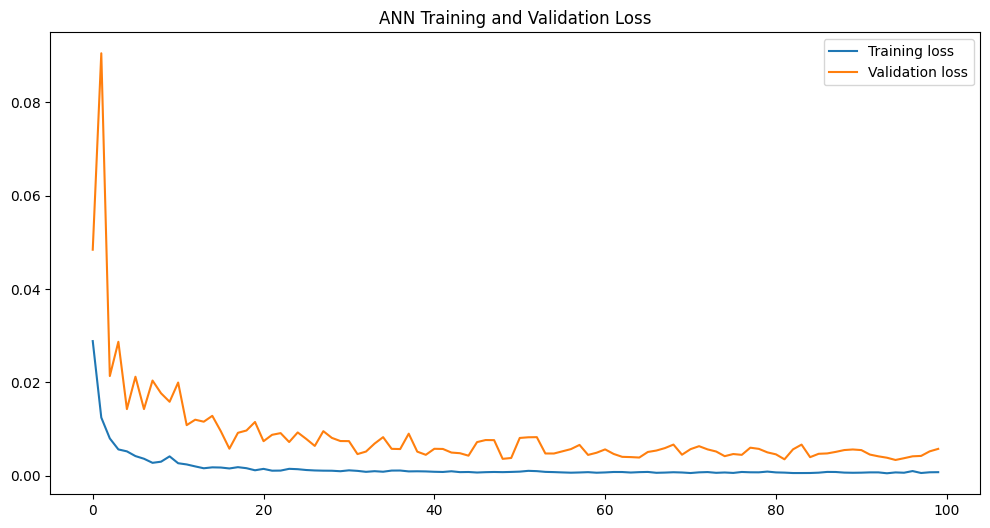

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [ ]:
len(test_predictions)

30

In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 36.3341
RMSE: 6.0278
MAE: 3.8857
MAPE: 91.89%
R²: 0.9277


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 36.3341
RMSE: 6.0278
MAE: 3.8857
MAPE: 91.89%
R²: 0.9277


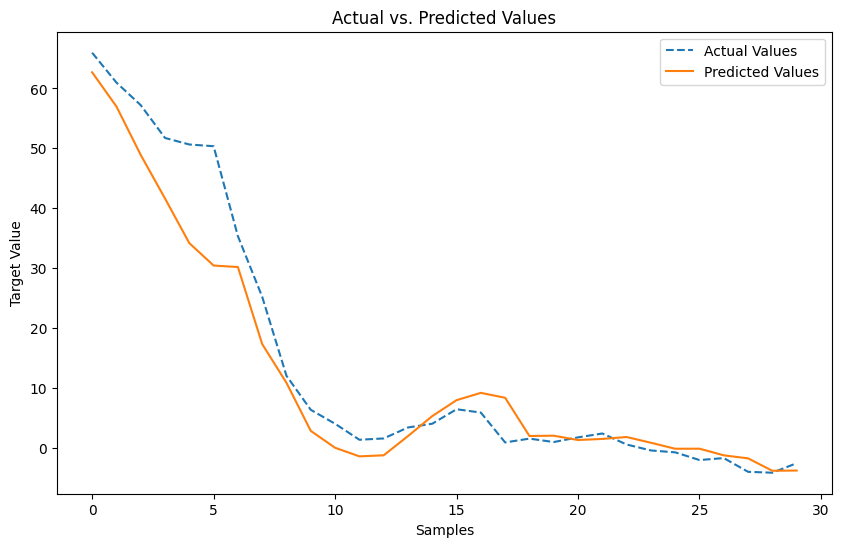

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 11

In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 11
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-12-31  10.836729         7.559566         7.794494         8.455851   
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

292

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0
Inflation_lag_9,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,,
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-04-30,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520,6.415695,3.997868
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520,6.415695
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,,
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-04-30,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275


In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,,
2000-12-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-04-30,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2000-12-31,10.836729
2001-01-31,16.170425
2001-02-28,16.618124
2001-03-31,13.213922
2001-04-30,13.874019
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,
2000-12-31,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-02-28,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-03-31,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-04-30,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.1071156 , 0.11731426, 0.14300296, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.15866734, 0.11340183, 0.13072938, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.24256957, 0.16797895, 0.12636955, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, ..., 0.25017212, 0.18110379,
        0.20278426],
       [0.94456676, 0.89738255, 0.71226688, ..., 0.33396706, 0.25017212,
        0.19347197],
       [1.        , 1.        , 1.        , ..., 0.41342656, 0.33396706,
        0.26149712]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-03-31,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-04-30,0.196062,0.264261,0.286171,0.262806,0.234185,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.179799,0.176431
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.190559,0.192187
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.181104,0.202784


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,,
2000-12-31,10.836729,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2001-01-31,16.170425,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2001-02-28,16.618124,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-03-31,13.213922,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-04-30,13.874019,0.196062,0.264261,0.286171,0.262806,0.234185,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.179799,0.176431
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.190559,0.192187
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.181104,0.202784


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11
Date,,,,,,,,,,,
2000-12-31,0.107116,0.117314,0.143003,0.237776,0.322924,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-03-31,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-04-30,0.196062,0.264261,0.286171,0.262806,0.234185,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.179799,0.176431
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.190559,0.192187
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.181104,0.202784


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-04-08 05:10:26,538] A new study created in memory with name: no-name-30bc1341-8dd1-4fef-9394-f5fcd41d7be5
[I 2025-04-08 05:10:41,448] Trial 0 finished with value: 0.0033430524985305966 and parameters: {'input_units': 16, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.0007544030549843095, 'n_units_1': 128, 'dropout_rate_1': 0.4555979022919411, 'optimizer': 'RMSprop', 'batch_size': 64, 'epochs': 50}. Best is trial 0 with value: 0.0033430524985305966.
[I 2025-04-08 05:11:00,331] Trial 1 finished with value: 0.00391613082611002 and parameters: {'input_units': 80, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 112, 'dropout_rate_0': 0.15780988723122008, 'n_units_1': 96, 'dropout_rate_1': 0.017190589270882628, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 50}. Best is trial 0 with value: 0.0033430524985305966.
[I 2025-04-08 05:11:12,340] Trial 2 finished with value: 0.016568122338503598 and parameters: {'input_units': 128, 'activation': 'relu', 'n

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.06621925114926648, 'n_units_1': 16, 'dropout_rate_1': 0.12090315115719925, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 70}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 128, 'activation': 'tanh', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.06621925114926648, 'n_units_1': 16, 'dropout_rate_1': 0.12090315115719925, 'optimizer': 'Adam', 'batch_size': 32, 'epochs': 70}
Epoch 1/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0443 - mae: 0.1540 - val_loss: 0.0634 - val_mae: 0.1485
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0129 - mae: 0.0883 - val_loss: 0.0934 - val_mae: 0.1750
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0115 - mae: 0.0772 - val_loss: 0.0159 - val_mae: 0.0764
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - mae: 0.0598 - val_loss: 0.0102 - val_mae: 0.0583
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0061 - mae: 0.0557 - val_loss: 0.0364 - val_mae: 0.1206
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0076 - mae: 0.0613 - val_loss: 0.0123 - val_mae: 0.0696
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.00

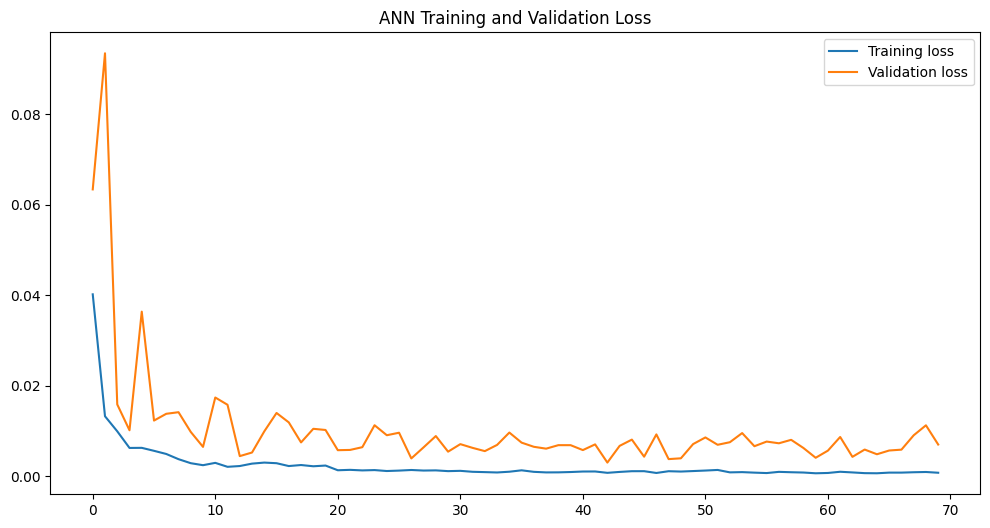

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [ ]:
from sklearn.metrics import r2_score

# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# R-squared (R²)
r2 = r2_score(y_test_original, test_predictions)

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")


MSE: 37.3125
RMSE: 6.1084
MAE: 4.5467
MAPE: 119.32%
R²: 0.9258


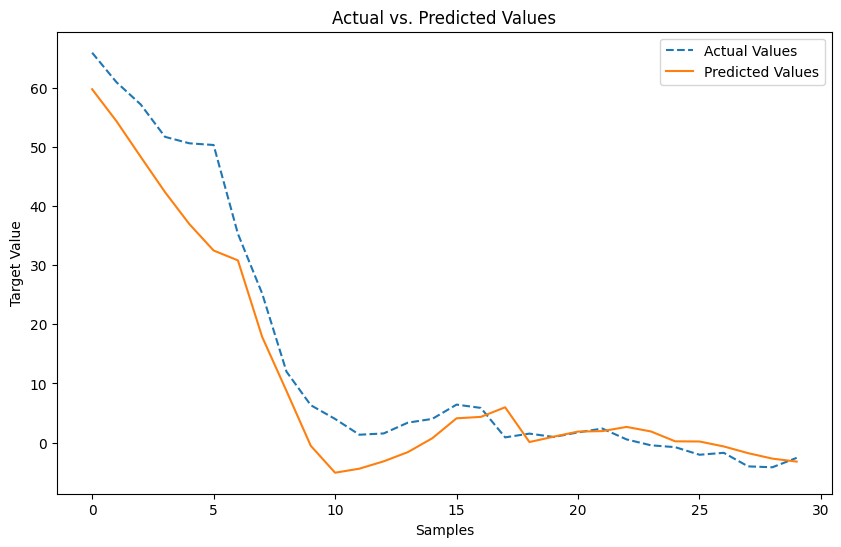

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## 12

In [ ]:
data

,Inflation
Date,
2000-01-31,0.329139
2000-02-28,1.940367
2000-03-31,4.469678
2000-04-30,3.672022
2000-05-31,2.382412
...,...
2024-11-30,-2.068252
2024-12-31,-1.742696
2025-01-31,-4.035874


In [ ]:

df=data.copy()
df = df.astype(float)


In [ ]:
# Function to create lagged features
def create_lagged_features(df, lags):
    lagged_df = df.copy()
    for col in df.columns:
        for lag in range(1, lags + 1):
            lagged_df[f"{col}_lag_{lag}"] = df[col].shift(lag)
    return lagged_df



In [ ]:
# Number of lags to create
lags = 12
lagged_features = create_lagged_features(df, lags)


In [ ]:
print("Original DataFrame:")
print(df)



Original DataFrame:
            Inflation
Date                 
2000-01-31   0.329139
2000-02-28   1.940367
2000-03-31   4.469678
2000-04-30   3.672022
2000-05-31   2.382412
...               ...
2024-11-30  -2.068252
2024-12-31  -1.742696
2025-01-31  -4.035874
2025-02-28  -4.187438
2025-03-31  -2.592781

[303 rows x 1 columns]


In [ ]:
print("\nDataFrame with Lagged Features:")
print(lagged_features)


DataFrame with Lagged Features:
            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2000-01-31   0.329139              NaN              NaN              NaN   
2000-02-28   1.940367         0.329139              NaN              NaN   
2000-03-31   4.469678         1.940367         0.329139              NaN   
2000-04-30   3.672022         4.469678         1.940367         0.329139   
2000-05-31   2.382412         3.672022         4.469678         1.940367   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874

In [ ]:
print(lagged_features.columns)

Index(['Inflation', 'Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11', 'Inflation_lag_12'],
      dtype='object')


In [ ]:
df2=lagged_features.dropna()

In [ ]:
print(df2)
len(df2)

            Inflation  Inflation_lag_1  Inflation_lag_2  Inflation_lag_3  \
Date                                                                       
2001-01-31  16.170425        10.836729         7.559566         7.794494   
2001-02-28  16.618124        16.170425        10.836729         7.559566   
2001-03-31  13.213922        16.618124        16.170425        10.836729   
2001-04-30  13.874019        13.213922        16.618124        16.170425   
2001-05-31  16.256885        13.874019        13.213922        16.618124   
...               ...              ...              ...              ...   
2024-11-30  -2.068252        -0.783699        -0.469239         0.526039   
2024-12-31  -1.742696        -2.068252        -0.783699        -0.469239   
2025-01-31  -4.035874        -1.742696        -2.068252        -0.783699   
2025-02-28  -4.187438        -4.035874        -1.742696        -2.068252   
2025-03-31  -2.592781        -4.187438        -4.035874        -1.742696   

           

291

In [ ]:
df2.isnull().sum()

,0
Inflation,0
Inflation_lag_1,0
Inflation_lag_2,0
Inflation_lag_3,0
Inflation_lag_4,0
Inflation_lag_5,0
Inflation_lag_6,0
Inflation_lag_7,0
Inflation_lag_8,0
Inflation_lag_9,0


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
df2

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,,
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-04-30,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-05-31,16.256885,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520,6.415695,3.997868,3.367183
2024-12-31,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520,6.415695,3.997868
2025-01-31,-4.035874,-1.742696,-2.068252,-0.783699,-0.469239,0.526039,2.365931,1.716069,0.936037,1.508060,0.871795,5.857520,6.415695


In [ ]:
train_size = int(len(df2) * 0.9)
train_data = df2.iloc[:train_size]
test_data = df2.iloc[train_size:]

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,,
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-04-30,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-05-31,16.256885,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598,4.545455
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854


In [ ]:
xtrain=train_data.drop(columns=['Residuals_SVR'])
xtest=test_data.drop(columns=['Residuals_SVR'])

In [ ]:
train_data

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,,
2001-01-31,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-02-28,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-03-31,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-04-30,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-05-31,16.256885,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598,4.545455
2022-06-30,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598
2022-07-31,60.796646,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854


In [ ]:
#ytrain=train_data['date','textile_exports']
ytrain=train_data["Residuals_SVR"]
ytest=test_data["Residuals_SVR"]
ytest

,Inflation
Date,
2022-10-31,65.963240
2022-11-30,60.982084
2022-12-31,57.207498
2023-01-31,51.729686
2023-02-28,50.635930
2023-03-31,50.346955
2023-04-30,35.327234
2023-05-31,25.195313
2023-06-30,11.997670


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
xtrain.columns

Index(['Inflation_lag_1', 'Inflation_lag_2', 'Inflation_lag_3',
       'Inflation_lag_4', 'Inflation_lag_5', 'Inflation_lag_6',
       'Inflation_lag_7', 'Inflation_lag_8', 'Inflation_lag_9',
       'Inflation_lag_10', 'Inflation_lag_11', 'Inflation_lag_12'],
      dtype='object')

In [ ]:
ytrain

,Inflation
Date,
2001-01-31,16.170425
2001-02-28,16.618124
2001-03-31,13.213922
2001-04-30,13.874019
2001-05-31,16.256885
...,...
2022-05-31,39.130435
2022-06-30,54.634831
2022-07-31,60.796646


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit and transform the training data for X (features)
X_train_scaled = scaler_X.fit_transform(xtrain)
X_test_scaled = scaler_X.transform(xtest)

# Reshape ytrain and ytest to be 2D arrays
y_train_reshaped = ytrain.values.reshape(-1, 1)  # Convert to NumPy and reshape
y_test_reshaped = ytest.values.reshape(-1, 1)

# Fit and transform the training data for y (target)
y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)


In [ ]:
'''# Step 2: Initialize the Min-Max Scaler
scaler = MinMaxScaler()

# Step 3: Fit the scaler on the training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(xtrain)
X_test_scaled = scaler.transform(xtest)'''

'# Step 2: Initialize the Min-Max Scaler\nscaler = MinMaxScaler()\n\n# Step 3: Fit the scaler on the training data and transform both train and test sets\nX_train_scaled = scaler.fit_transform(xtrain)\nX_test_scaled = scaler.transform(xtest)'

In [ ]:
xtrain

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,
2001-01-31,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367,0.329139
2001-02-28,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678,1.940367
2001-03-31,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022,4.469678
2001-04-30,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412,3.672022
2001-05-31,13.874019,13.213922,16.618124,16.170425,10.836729,7.559566,7.794494,8.455851,9.876072,10.139831,6.799835,2.382412
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598,4.545455
2022-06-30,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854,5.247598
2022-07-31,54.634831,39.130435,29.827089,18.718503,15.097052,14.203317,12.101449,9.919767,7.619048,5.722671,5.982275,5.686854


In [ ]:
df1=pd.DataFrame(ytrain)

In [ ]:
X_train_scaled

array([[0.15866734, 0.11340183, 0.13072938, ..., 0.13546829, 0.04334777,
        0.        ],
       [0.24256957, 0.16797895, 0.12636955, ..., 0.1064167 , 0.13546829,
        0.05779654],
       [0.24961214, 0.25680511, 0.18718768, ..., 0.05944757, 0.1064167 ,
        0.14852572],
       ...,
       [0.84763773, 0.63917587, 0.53961388, ..., 0.18110379, 0.19055889,
        0.19218718],
       [0.94456676, 0.89738255, 0.71226688, ..., 0.25017212, 0.18110379,
        0.20278426],
       [1.        , 1.        , 1.        , ..., 0.33396706, 0.25017212,
        0.19347197]])

In [ ]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=xtrain.columns, index=xtrain.index)

In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2001-03-31,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-04-30,0.196062,0.264261,0.286171,0.262806,0.234185,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-05-31,0.206446,0.207568,0.294480,0.401775,0.346892,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.179799,0.163801,0.151244
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.190559,0.179799,0.176431
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.181104,0.190559,0.192187


In [ ]:
df3= pd.concat([df1, X_train_scaled_df], axis=1)


In [ ]:
df3

,Inflation,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,,
2001-01-31,16.170425,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2001-02-28,16.618124,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2001-03-31,13.213922,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-04-30,13.874019,0.196062,0.264261,0.286171,0.262806,0.234185,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-05-31,16.256885,0.206446,0.207568,0.294480,0.401775,0.346892,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,39.130435,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.179799,0.163801,0.151244
2022-06-30,54.634831,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.190559,0.179799,0.176431
2022-07-31,60.796646,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.181104,0.190559,0.192187


In [ ]:
X_train_scaled_df

,Inflation_lag_1,Inflation_lag_2,Inflation_lag_3,Inflation_lag_4,Inflation_lag_5,Inflation_lag_6,Inflation_lag_7,Inflation_lag_8,Inflation_lag_9,Inflation_lag_10,Inflation_lag_11,Inflation_lag_12
Date,,,,,,,,,,,,
2001-01-31,0.158667,0.113402,0.130729,0.200772,0.313853,0.341982,0.220335,0.059448,0.106417,0.135468,0.043348,0.000000
2001-02-28,0.242570,0.167979,0.126370,0.183540,0.265010,0.332376,0.341982,0.220335,0.059448,0.106417,0.135468,0.057797
2001-03-31,0.249612,0.256805,0.187188,0.177419,0.242265,0.280650,0.332376,0.341982,0.220335,0.059448,0.106417,0.148526
2001-04-30,0.196062,0.264261,0.286171,0.262806,0.234185,0.256562,0.280650,0.332376,0.341982,0.220335,0.059448,0.119913
2001-05-31,0.206446,0.207568,0.294480,0.401775,0.346892,0.248006,0.256562,0.280650,0.332376,0.341982,0.220335,0.073653
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-31,0.457397,0.299240,0.266251,0.350522,0.390388,0.333967,0.250172,0.181104,0.190559,0.179799,0.163801,0.151244
2022-06-30,0.603744,0.484240,0.333459,0.373809,0.462674,0.413427,0.333967,0.250172,0.181104,0.190559,0.179799,0.176431
2022-07-31,0.847638,0.639176,0.539614,0.468166,0.493411,0.489979,0.413427,0.333967,0.250172,0.181104,0.190559,0.192187


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import TimeSeriesSplit
import optuna



# Step 2: Define the function to create an ANN model with hyperparameter optimization
def create_ann_model(trial, X,y):
    model = Sequential()

    # Input layer
    model.add(Dense(units=trial.suggest_int("input_units", 16, 128, step=16), input_dim=X.shape[1]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "sigmoid"])
    model.add(tf.keras.layers.Activation(activation))

    # Number of hidden layers
    num_layers = trial.suggest_int("num_layers", 1,3)

    # Add hidden layers
    for i in range(num_layers):
        num_units = trial.suggest_int(f"n_units_{i}", 16, 128, step=16)
        model.add(Dense(num_units))
        model.add(tf.keras.layers.Activation(activation))

        # Add dropout for regularization
        dropout_rate = trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))  # Single target variable

    # Optimizer selection
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = Adam()  # Default learning rate
    elif optimizer_name == "SGD":
        optimizer = SGD()   # Default learning rate
    else:
        optimizer = RMSprop()  # Default learning rate

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Step 3: Define the objective function for Optuna with TimeSeriesCV
def objective(trial, X, y):
    tscv = TimeSeriesSplit(n_splits=5)
    model = create_ann_model(trial, X_train_scaled_df, ytrain)
    batch_size = trial.suggest_int("batch_size", 16, 64, step=16)
    epochs = trial.suggest_int("epochs", 10, 100, step=10)

    val_scores = []
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y[train_index], y[val_index]


        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        loss = model.evaluate(X_val, y_val, verbose=0)

        val_scores.append(loss)


    return np.mean(val_scores)

# Step 4: Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, X_train_scaled_df, y_train_scaled ), n_trials=50)

# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-04-08 05:29:07,552] A new study created in memory with name: no-name-7bcd7411-4e16-4c12-b3fa-4cd45fb23f16
[I 2025-04-08 05:29:21,305] Trial 0 finished with value: 0.019649963080883025 and parameters: {'input_units': 128, 'activation': 'sigmoid', 'num_layers': 2, 'n_units_0': 128, 'dropout_rate_0': 0.13447326428679923, 'n_units_1': 16, 'dropout_rate_1': 0.3357240336623223, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 40}. Best is trial 0 with value: 0.019649963080883025.
[I 2025-04-08 05:29:52,501] Trial 1 finished with value: 0.0171960505656898 and parameters: {'input_units': 32, 'activation': 'sigmoid', 'num_layers': 1, 'n_units_0': 112, 'dropout_rate_0': 0.43861797288103954, 'optimizer': 'RMSprop', 'batch_size': 16, 'epochs': 90}. Best is trial 1 with value: 0.0171960505656898.
[I 2025-04-08 05:30:08,680] Trial 2 finished with value: 0.0066347391461022195 and parameters: {'input_units': 48, 'activation': 'relu', 'num_layers': 2, 'n_units_0': 96, 'dropout_rate_0': 0.383000

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 32, 'dropout_rate_0': 0.05215273054322569, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 100}


Best hyperparameters:  {'input_units': 80, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 16, 'dropout_rate_0': 0.34258041424105734, 'optimizer': 'Adam', 'batch_size': 16, 'epochs': 80}

Best hyperparameters:  {'input_units': 64, 'activation': 'tanh', 'num_layers': 1, 'n_units_0': 32, 'dropout_rate_0': 0.05215273054322569, 'optimizer': 'Adam', 'batch_size': 48, 'epochs': 100}
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0092 - mae: 0.0691 - val_loss: 0.0418 - val_mae: 0.1159
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0044 - mae: 0.0507 - val_loss: 0.0437 - val_mae: 0.1202
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0037 - mae: 0.0438 - val_loss: 0.0185 - val_mae: 0.0805
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0031 - mae: 0.0419 - val_loss: 0.0229 - val_mae: 0.0855
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0029 - mae: 0.0390 - val_loss: 0.0172 - val_mae: 0.0712
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0023 - mae: 0.0339 - val_loss: 0.0157 - val_mae: 0.0682
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0028 - mae: 0.0369 - val_loss: 0.0181 - val_mae: 0.0

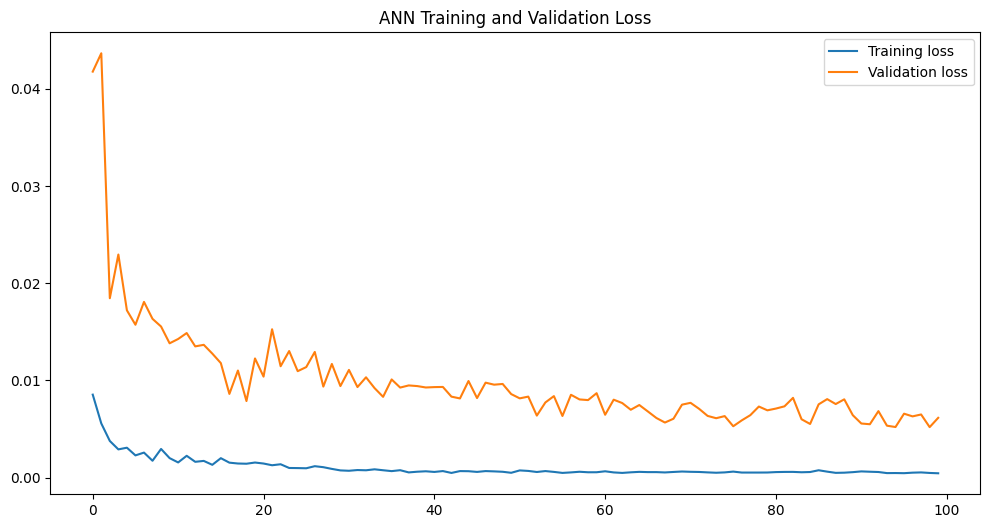

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Assuming `study` is already defined from your Optuna optimization process
# Step 5: Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)

# Extract the best hyperparameters from the Optuna study
best_params = study.best_params

# Build the ANN model
model = Sequential()

# Input layer
model.add(Dense(units=best_params['input_units'], input_dim=X_train_scaled_df.shape[1], activation=best_params['activation']))

# Adding hidden layers based on the number of layers suggested by Optuna
for i in range(best_params['num_layers']):
    # Dynamically get the number of units and dropout for each hidden layer
    num_units = best_params.get(f'n_units_{i}', 64)  # Default to 64 if not specified
    dropout_rate = best_params.get(f'dropout_rate_{i}', 0.3)  # Default to 0.3 if not specified

    model.add(Dense(units=num_units, activation=best_params['activation']))
    model.add(Dropout(rate=dropout_rate))

# Output layer (assuming a regression problem)
model.add(Dense(units=1))  # Single output for regression

# Optimizer (based on Optuna's suggestion)
optimizer_name = best_params['optimizer']
if optimizer_name == 'Adam':
    optimizer = Adam()
else:
    optimizer = Adam()  # You can add other optimizers here if needed

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Fit the model
history = model.fit(
    X_train_scaled_df, y_train_scaled,
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs'],
    validation_split=0.1,  # 10% of training data as validation
    verbose=1
)

# Print the final validation loss
final_loss, final_mae = model.evaluate(X_train_scaled_df, y_train_scaled, verbose=0)
print(f"Final Loss: {final_loss:.4f}")

# Plot training loss and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('ANN Training and Validation Loss')
plt.show()


In [ ]:
test_predictions_scaled=model.predict(X_test_scaled)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [ ]:
len(test_predictions)

30

In [ ]:
# Inverse transform predictions and actual values
test_predictions = scaler_y.inverse_transform(test_predictions_scaled)
y_test_original = scaler_y.inverse_transform(y_test_scaled)

# Mean Squared Error (MSE)
mse = mean_squared_error(y_test_original, test_predictions)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_original, test_predictions)

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test_original - test_predictions) / y_test_original)) * 100

# Print results
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

MSE: 90.2029
RMSE: 9.4975
MAE: 7.1185
MAPE: 137.53%


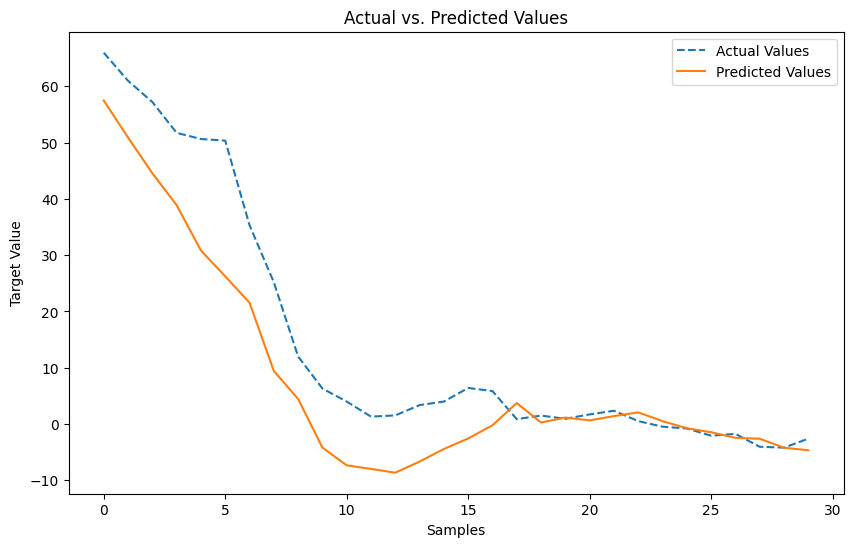

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label="Actual Values", linestyle='dashed')
plt.plot(test_predictions, label="Predicted Values",  linestyle='solid')
plt.xlabel("Samples")
plt.ylabel("Target Value")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

## K